In [1]:
#Import packages
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [2]:
nc_graph = ox.load_graphml('NC_roads.graphml', folder='../Data/OSM/')

In [3]:
type(nc_graph)

networkx.classes.multidigraph.MultiDiGraph

In [4]:
dcfc_df = pd.read_csv('../Data/NREL/DCFC.csv')

In [5]:
geom_point = [Point(xy) for xy in zip (dcfc_df['longitude'],dcfc_df['latitude'])]

In [6]:
dcfc_gdf = gpd.GeoDataFrame(dcfc_df, geometry=geom_point, crs = 4326)

In [7]:
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')

In [8]:
del(dcfc_df)


Link exit and dcfc features to their corresponding node in the roads network

In [9]:
thePoint = dcfc_gdf.at[0, 'geometry']

In [10]:
def get_nodeid(thePoint):
    yx = (thePoint.y, thePoint.x)
    return ox.get_nearest_node(nc_graph,yx)


In [11]:
dcfc_gdf['node_id'] = dcfc_gdf['geometry'].apply(get_nodeid)

In [12]:
exits_gdf['node_id'] = exits_gdf['geometry'].apply(get_nodeid)

In [13]:
nodes_dcfc = dcfc_gdf['node_id'].unique() 
nodes_exits = exits_gdf['node_id'].unique()

Compute Distances

In [14]:
theStartNode = nodes_dcfc[0]
theStartNode

169672458

In [15]:
thePaths = nx.single_source_dijkstra_path(G = nc_graph,
                                         source = theStartNode,
                                         weight = 'length',
                                         cutoff = 100 * 1609.34)

In [16]:
subgraph = nx.subgraph(nc_graph, thePaths.keys())
ox.plot_graph_folium(subgraph)

In [17]:
theDistances = nx.single_source_dijkstra_path_length(G = nc_graph,
                                                    source = theStartNode,
                                                    cutoff = 100 * 1609.34,
                                                    weight = 'length')

In [18]:
theDistances(169634378)

TypeError: 'dict' object is not callable

In [24]:
df = pd.DataFrame()
df['node_id'] = theDistances.keys()
df['distance'] = theDistances.values()
df['distance'] = df['distance']/1609.34
df.head()

node_id  distance
0   169672458  0.000000
1   169672461  0.008455
2  5567900585  0.016066
3  5567900584  0.024915
4  5567900513  0.246039

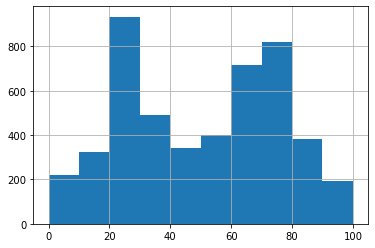

In [25]:
df['distance'].hist()

Compute All Distances

In [33]:
allDistPairs = nx.all_pairs_dijkstra_path_length(nc_graph,cutoff = 100*1609.34, weight = 'length')

In [28]:
type(allDistPairs)

generator

In [35]:
distance_data = {}
for distItem in allDistPairs: 
    #Get items in tuple
    startNode_id = distItem[0]
    path_data = distItem[1]
    #Chec to see if startNode is a DCFC node
    if startNode_id in nodes_dcfc: 
        #Get a list of end nodes from the path_data objecct
        endNodes = set(path_data.keys())
        #Find intersection of list of end nodes and exits
        valid_endNodes= endNodes.intersection(set(nodes_exits))
        #iterate through valid end nodes (ie those that are exits)
        for node in valid_endNodes:
            #See if node already has a recorded distance
            if node in distance_data.keys(): 
                #Check what the distance is relative to current DCFC- Exit istance
                if path_data[node] < distance_data[node]: 
                    distance_data[node] = path_data[node]
            else: distance_data[node] = path_data[node]
                
                

In [40]:
df_distance = pd.DataFrame()
df_distance['node_id'] = distance_data.keys()
df_distance['distance'] = distance_data.values()
df_distance['distance'] = df_distance['distance']/1609.34
df_distance.head()

node_id   distance
0  169570817  52.466489
1  488952337  30.830719
2  173223456  46.757092
3  171985959  41.157149
4  169842216  14.200237

In [45]:
exits_gdf1 = pd.merge(left=exits_gdf, 
                      right = df_distance,
                     left_on = 'node_id',
                     right_on = 'node_id',
                     how = 'left')

In [47]:
exits_gdf1.sample(10)

FID                     Exit_ID  Longitude   Latitude      County  \
1052  8111     US-70_Craven_NC_Exit_14 -76.941434  34.917541      Craven   
1164  8223      US-70_Wayne_NC_Exit_19 -77.953157  35.371276       Wayne   
599   7658    I-85_Granville_NC_Exit_1 -78.767022  36.079727   Granville   
670   7729      US-64_Martin_NC_Exit_1 -77.252616  35.836182      Martin   
707   7766  US-17_Perquimans_NC_Exit_8 -76.461449  36.178146  Perquimans   
906   7965       US-64_Wake_NC_Exit_14 -78.851120  35.749842        Wake   
1141  8200       US-64_Dare_NC_Exit_16 -75.644274  35.892619        Dare   
456   7515     I-77_Iredell_NC_Exit_11 -80.854515  35.917395     Iredell   
550   7609    I-40_Guilford_NC_Exit_10 -79.769165  36.046128    Guilford   
977   8036      US-17_Onslow_NC_Exit_6 -77.480043  34.635944      Onslow   

     State          Highway               Type   AADT     Pop_dens  Comm_1mi  \
1052    NC  U.S. Highway 70  Exit/Intersection  32000   568.118658        10   
1164    NC  U.S. Highway 70  Exit/Intersection   9400   912.905745        62   
599     NC    Interstate 85  Exit/Intersection  50000   252.541665         1   
670     NC  U.S. Highway 64  Exit/Intersection  11000    78.193617         4   
707     NC  U.S. Highway 17  Exit/Intersection  13000   100.899061         8   
906     NC  U.S. Highway 64  Exit/Intersection  35000  2446.311981         8   
1141    NC  U.S. Highway 64  Exit/Intersection  20000   162.559036         2   
456     NC    Interstate 77  Exit/Intersection  37000    84.781989         1   
550     NC    Interstate 40  Exit/Intersection  70000  1156.234298         8   
977     NC  U.S. Highway 17  Exit/Intersection  23000   136.029095         0   

      Ports_5mi  Ports_10mi  Ports_20mi  Close_nonT  \
1052          0           0           0   58.276866   
1164          0           0           0   26.553131   
599           0           2          22    9.615761   
670           0           0           0   37.266930   
707           0           0           0   43.459898   
906           2           9          30    1.255585   
1141          0           0           0   69.645400   
456           0           0           0   26.481655   
550           2           5           6    2.025351   
977           0           0           0   27.907582   

                        geometry    node_id   distance  
1052  POINT (-76.94143 34.91754)  169329445  78.026995  
1164  POINT (-77.95316 35.37128)  195770937   1.777820  
599   POINT (-78.76702 36.07973)  493015567  16.124560  
670   POINT (-77.25262 35.83618)  454577212  48.719445  
707   POINT (-76.46145 36.17815)  195508267  95.965690  
906   POINT (-78.85112 35.74984)  195400458   1.629803  
1141  POINT (-75.64427 35.89262)  170368926   0.000000  
456   POINT (-80.85451 35.91740)  171586703  66.415393  
550   POINT (-79.76917 36.04613)  171079634   6.239867  
977   POINT (-77.48004 34.63594)  172756131  92.513152

In [48]:
exits_gdf1.to_file('../Data/processed/exits_distances.shp')

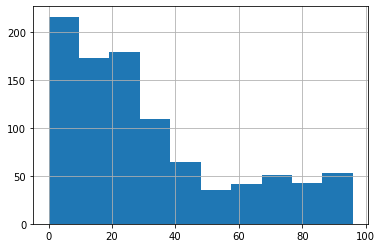

In [49]:
exits_gdf1['distance'].hist(bins=10);

In [51]:
exit_colors = []
for d in exits_gdf1['distance']:
    if d < 50: exit_colors.append('grey') #show exits <50 miles from dcfc as grey
    else: exit_colors.append('red') #show all other exits as red
            

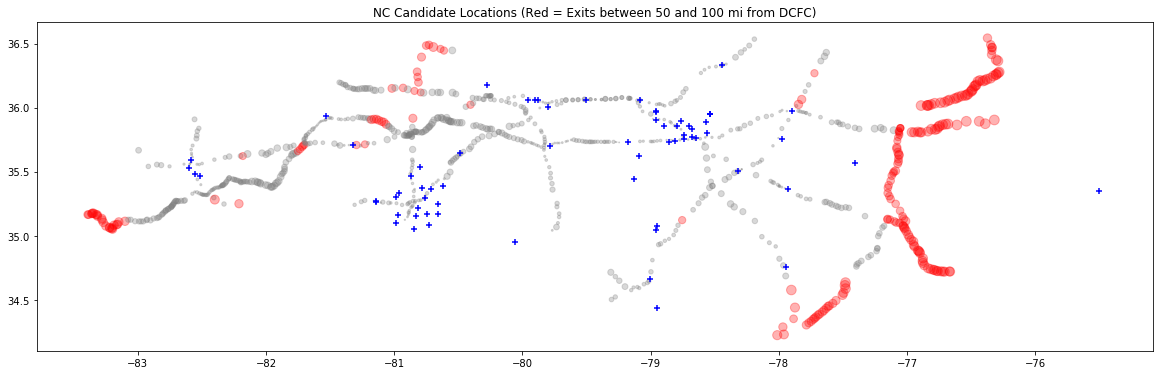

In [53]:
ax = exits_gdf1.plot(markersize = 'distance', #Make further exits larger
                   figsize = (20,15),        #Size of figure
                   color = exit_colors,      #Use colors set above
                   alpha = 0.3)              #Set to mostly transparent
ax.set_title("NC Candidate Locations (Red = Exits between 50 and 100 mi from DCFC)")

#Add dcfc lcoations as small blue crosses
dcfc_gdf.plot(color = 'blue', marker = '+', ax=ax)